# BACKGROUND
coalescent simulation(Bacward time simulations) VS Forward time simulations  
=> Complex 하지만, flexibility 가 높다.

## Examples...
Data: 26 MM, 68 MN, 106 NN, with a total population of 200 individuals.
### 1. Observed genotype frequencies:   
MM: 26/200 = 0.13  
MN: 68/200 = 0.34  
NN:106/200 = 0.53  
### 2. Allele frequencies:  
M: 0.13 + 1/2 * 0.34 = 0.30  
N: 0.53 + 1/2 * 0.34 = 0.70  
### 3. Expected genotype frequencies and numbers:  
MM: p2 = (0.30)2 = 0.09 (freq) x 200 = 18  
MN: 2pq = 2 * 0.3 * 0.7 = 0.42 (freq) * 200 = 84  
NN: q2 = (0.70)2 = 0.49 (freq) * 200 = 98  

## Hardy-Weinberg Equilibrium:
![H-W 원칙](http://cfile299.uf.daum.net/image/1467721A4C39D2C35EE0A6) 

성립조건: 현실세계에서는 있을수 없다.
1. no new mutations  => x
2. no migration in or out of the population => x
3. no selection (all genotypes have equal fitness) => x
4. random mating => x
5. very large population => x

## simuPOP is:
1. individual-based population genetics simulation program
2. Forward-time
3. General-purpose
4. A simulation environment: population, mating schemes, operators

![simupop](http://simupop.sourceforge.net/images/evolve.png)

In [2]:
from collections import OrderedDict
from copy import deepcopy # We will use deepcopy to make sure that we have our own copy of the variable because it can be changed by a future operator.

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (May  1 2015) for Python 2.7.9 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0x64db495f4055f2ef.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


/home/seung-hyun/anaconda/envs/bioinformatics/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
num_loci = 10
pop_size = 100
num_gens = 10

# So, we specify that we want to simulate 10 loci, a population size of 100, and just 10 generations

In [4]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

# Ordered dictionaries will return keys in the order that they were inserted.

In [5]:
pops = sp.Population(pop_size, loci=[1] * num_loci)

# We start by creating the meta population with a single deme of the required size and 10 independent loci

In [6]:
init_ops['Sex'] = sp.InitSex() # 1 Operator : sex
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5]) # 2 Operator : allele frequency
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL) # 가능한 모든 allele 에서 freq 를 구한다.
post_ops['Stat-freq-eval'] = sp.PyEval(r"'%d %.2f\n' % (gen, alleleFreq[0][0])") # generation 과 allele frequnecy를 계산.

In [7]:
mating_scheme = sp.RandomMating() # Random mating 을 할경우.

In [8]:
sim = sp.Simulator(pops, rep=1) # 1개의 replication 으로 simulation 시작.
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)
# 시행시 마다 다른값이 나온다 => operator 값들이 random이기 때문.

0 0.46
1 0.51
2 0.51
3 0.51
4 0.55
5 0.57
6 0.56
7 0.53
8 0.53
9 0.56


(10L,)

In [9]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

# Two operator : initial, update
# update acuculator 는 값이 계속 append 된다.


In [10]:
# expected heterozygosity 를 allelic frequency 로부터 계산한다.

def calc_exp_he(pop):
    #assuming bi-allelic markers coded as 0 and 1
    #sample size not corrected - OK
    pop.dvars().expHe = {}
    for locus, freqs in pop.dvars().alleleFreq.items():
        f0 = freqs[0]
        pop.dvars().expHe[locus] = 1 - f0**2 - (1 - f0)**2
    return True




In [11]:
# two accumulators (num_males and exp_he) 가 initialization operator 로 추가됨
# 4개의 Post-operator를 추가한다. 

# numOFMales => 현재 generation의 남자수, num_of_males => 계속 append 된다.
# exp_he 도 마찬가지.

init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['num_males', 'exp_he'])
post_ops['Stat-males'] = sp.Stat(numOfMales=True)
post_ops['ExpHe'] = sp.PyOperator(calc_exp_he)
post_ops['male_accumulation'] = sp.PyOperator(update_accumulator, param=('num_males', 'numOfMales'))
post_ops['expHe_accumulation'] = sp.PyOperator(update_accumulator, param=('exp_he', 'expHe'))



In [12]:
del post_ops['Stat-freq-eval'] # 여기서는 allel freq 를 내보내지 않으므로 삭제.


In [13]:
# compare two populations with population sizes of 40 and 500
num_gens = 100
pops_500 = sp.Population(500, loci=[1] * num_loci)
sim = sp.Simulator(pops_500, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)



(100L,)

In [14]:
pop_500_after = deepcopy(sim.population(0))

In [15]:
pops_40 = sp.Population(40, loci=[1] * num_loci)
sim = sp.Simulator(pops_40, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)



(100L,)

In [16]:
pop_40_after = deepcopy(sim.population(0))


In [17]:
# plot the loss of heterozygosity and the distribution of number of males
# Mean LOH 를 구하기 위해 아래 함수이용

def calc_loci_stat(var, fun):
    stat = []
    for gen_data in var:
        stat.append(fun(gen_data.values()))
    return stat

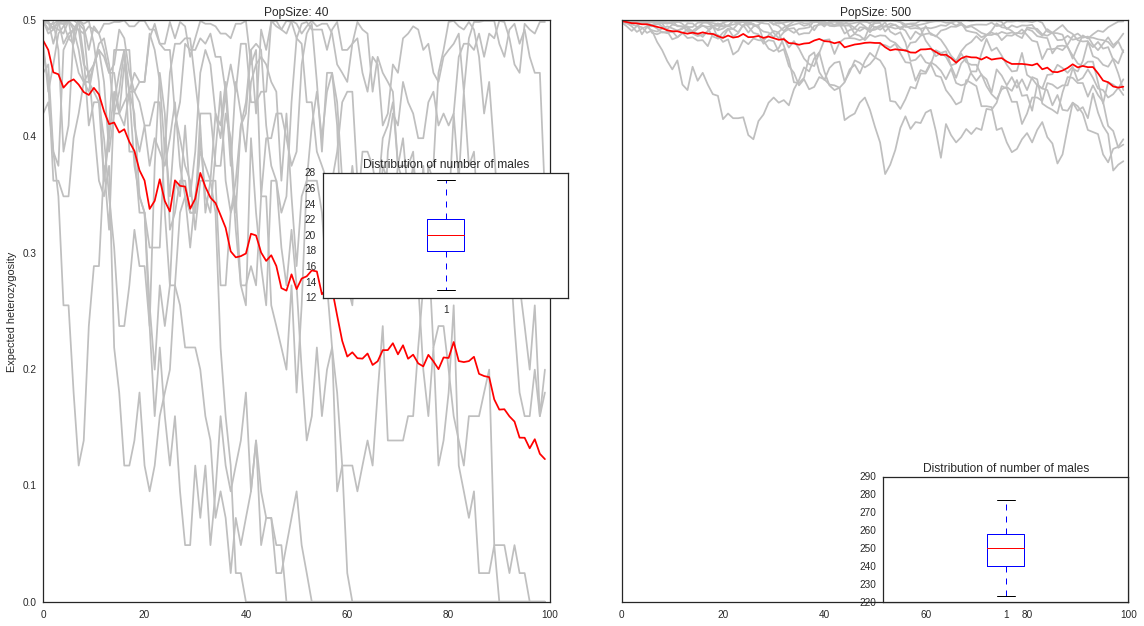

In [18]:
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True, squeeze=False)
def plot_pop(ax1, pop):
    for locus in range(num_loci):
        ax1.plot([x[locus] for x in pop.dvars().exp_he], color=(0.75, 0.75, 0.75))
    mean_exp_he = calc_loci_stat(pop.dvars().exp_he, np.mean)
    ax1.plot(mean_exp_he, color='r')

axs[0, 0].set_title('PopSize: 40')
axs[0, 1].set_title('PopSize: 500')
axs[0, 0].set_ylabel('Expected heterozygosity')
plot_pop(axs[0, 0], pop_40_after)
plot_pop(axs[0, 1], pop_500_after)
ax = fig.add_subplot(4, 4, 6)
ax.set_title('Distribution of number of males')
ax.boxplot(pop_40_after.dvars().num_males)
ax = fig.add_subplot(4, 4, 16)
ax.set_title('Distribution of number of males')
ax.boxplot(pop_500_after.dvars().num_males)
fig.tight_layout()

# Major plots show the decrease in expected heterozygosity.
# bigger loss in the smaller population with bigger variance
# Gray lines depict the individual loci, whereas the red line shows the mean.

# box plots; they show the distribution of the number of males produced in each generation.